# Differences-in-Differences: Progresa Dataset

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa
program](http://en.wikipedia.org/wiki/Oportunidades), a government
social assistance program in Mexico. This program, as well as the
details of its impact, are described in the paper "[School subsidies
for the poor: evaluating the Mexican Progresa poverty
program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)",
by Paul Shultz (available on Canvas).

The goal of this problem set is to implement some of the basic
econometric techniques that you are learning in class to measure the
impact of Progresa on secondary school enrollment rates, in particular
differences-in-differences.  Your task is to **estimate the impact of
_progresa_ subsidies on the school attendance**.  Note: this asks to
estimate a causal effect.

The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
The data are actual data collected to evaluate the impact of
the Progresa program.  In this file, each row corresponds to an
observation taken for a given child for a given year. There are two
years of data (1997 and 1998), and just under 40,000 children who are
surveyed in both years.  For each child-year observation, the
following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey (=1)|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = "pobre", not poor = "no pobre"|
|progresa |treatment = "basal", control = "0"|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|enrolled in school in 1997 (=1) |

In [238]:
#Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import scipy as ap
import pandas as pd
import sklearn
import os
from scipy import stats
from scipy.stats import binom
from scipy.stats import bernoulli
import random
import statsmodels.formula.api as smf

## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Report summary statistics (mean, standard deviation, and number of missings) for all of
the demographic variables in the dataset (i.e., everything except
year, folnum, village).  A central variable, _progresa_ is coded in a
rather unintuitive way.  Find it's actual coding scheme (levels).  Does this fit with the documentation above?

Present these in a single table alphabetized
by variable name. Do NOT simply expect the grader to scroll through
your output!

In [245]:
# Loading the data
path = os.getcwd()
#print(path)
dataPath = path + "/data/progresa_sample.csv.gz"
data = pd.read_csv(dataPath)

In [246]:
#Encoding the data in the "poor" and the "progresa" columns as per the description given above
data.poor = data['poor'].map({'no pobre': 0, 'pobre': 1})
data.progresa = data['progresa'].map({'basal': 1, '0': 0})

In [251]:
#Dropping the columns not required
data2 = data.drop(columns = ["year", "folnum", "village"], axis=1)
mean = data2.mean(axis=0) #Calculating mean of each column
std = data2.std(axis=0)   #Calculating std deviation of each column 
missingValues = data2.isna().sum() #Calculating number of missing values of each column

#Collating data in a data frame
info = pd.DataFrame({'Columns':mean.index, 'Mean':mean.values, 
                     'Std Deviation':std.values, '# of Missing Values':missingValues.values})

print("\n\t\t\tAlphabetized Variable Names and their details are given below\n")
info = info.sort_values("Columns") #Sorting the data-frame alphabetically
print(info)


			Alphabetized Variable Names and their details are given below

          Columns        Mean  Std Deviation  # of Missing Values
15            age   11.366460       3.167744                    0
7        dist_cap  147.674452      76.063134                    0
2        dist_sec    2.418910       2.234109                    0
5           fam_n    7.215715       2.352900                    0
4             grc    3.963537       2.499063                 6549
16          grc97    3.705372       2.572387                    0
14         hohage   44.436717      11.620372                   10
10         hohedu    2.768104       2.656106                    0
13         hohsex    0.925185       0.263095                   20
11         hohwag  586.985312     788.133664                    0
1           indig    0.298324       0.457525                  300
6        min_dist  103.447520      42.089441                    0
8            poor    0.846498       0.360473                    0
9        

### 1.2 Differences at baseline?
Now let's investigate the differences in baseline.  Are the baseline (1997) demographic characteristics **for the poor**
different in treatment and control villages?

I suggest you to use a T-Test to
determine whether there is a statistically significant difference in
the average values of each of the variables in the dataset. Focus only
on the data from 1997 for poor.

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|


In [257]:
#Subsetting the dataset for the year 1997 and the poor population
data3 = data[(data["year"] == 97) & (data["poor"] == 1)]

#Dropping the na values; This is required because the p-value is 
#not calculated if we take into account the NaN values
data3 = data3.dropna(axis = 0, how = 'any')

#Calculating the mean of all the columns for the treatment group
avgTreatment = data3[(data3["progresa"]==1)].mean(axis=0)

#Calculating the mean of all the columns for the control group
avgControl = data3[(data3["progresa"]==0)].mean(axis=0)

#Calculating the p-values of all the columns for both the treatment as well as the control group
#equal variance parameter = False, because the poor families in 1997 were not necesserily the same 
#poor families in 1998
pValues = stats.ttest_ind(data3[data3["progresa"]==1], data3[data3["progresa"]==0], equal_var=False).pvalue

#Collating into a data frame
baseline = pd.DataFrame({'Variable Name':avgTreatment.index, 
                         'Average value (Treatment villages)':avgTreatment.values, 
                         'Average value (Control villages)':avgControl.values})

#Calculating the difference in values of the treatment and the control group
baseline['Difference (Treat - Control)'] = baseline.iloc[:,1] - baseline.iloc[:,2]
baseline['p-value'] = np.round(pValues,5)

#Getting rid of the unwanted column names
baseline = baseline[~baseline['Variable Name'].isin(['year', 'village', 'poor', 'folnum', 'progresa'])]

print("\n\t\t\tVariable Names and their details are given below\n")
baseline


			Variable Names and their details are given below



,Variable Name,Average value (Treatment villages),Average value (Control villages),Difference (Treat - Control),p-value
1,sex,0.520268,0.506556,0.013713,0.01959
2,indig,0.316744,0.325306,-0.008562,0.11900
3,dist_sec,2.399648,2.400687,-0.001039,0.96807
4,sc,0.822697,0.815066,0.007631,0.09247
5,grc,3.709214,3.733653,-0.024439,0.39551
6,fam_n,7.281032,7.302939,-0.021907,0.42605
7,min_dist,107.395231,103.098348,4.296884,0.00000
8,dist_cap,151.801472,154.492095,-2.690622,0.00436
11,hohedu,2.726729,2.660982,0.065747,0.02496
12,hohwag,550.207086,580.694452,-30.487366,0.00029


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

The t test, under the assumption that the dependent variable fits a normal distribution, is used to determine whether there is a significant difference between the means of two groups. From the above table we can infer that:

* P-Values of only a few variables (sex, min_dist, dist_cap, hohedu, hohwag, welfare_index, hohage) is less that 0.05. This means that the difference in means of these variables when considering the treatment and the control groups is statistically significant and is not by chance. The opposite is true for the variables for which the p-value > 0.05.

* If there are differences at the baseline this is indicative of the fact that the 

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average
enrollment rate in 1997. Create a scatterplot that shows this
relationship. What do you notice?

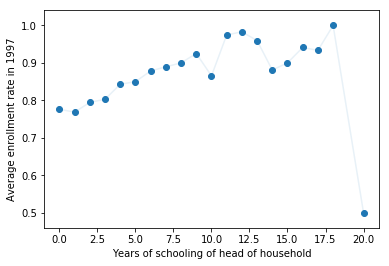

In [260]:
#flights_df.groupby(["month","day"], as_index=False).agg({"dep_delay":"mean","arr_delay":"mean"})
#data4 = 
#data.groupby(["hohedu"]).agg({"sc97":mean})
x = data.groupby(['hohedu'])['sc97'].mean()
y = x.values
x = x.index
plt.scatter(x,y)

plt.plot(data.groupby(['hohedu'])['sc97'].mean(), alpha=0.1)
plt.xlabel("Years of schooling of head of household")
plt.ylabel("Average enrollment rate in 1997")
plt.show()

* From above graph we can conclude that there is a steady increase in the enrollment of the children in 1997 when the head of the household has studied for a longer time. However, when the head of the households have had about 20 years of schooling, the avg enrollment rate for the children in that household drops significantly.

* A reason can be that with increased education of the head of household they tend to earn a lot more, and the children in that household are more likely to be homeschooled and hence the low enrollment rates.

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households
in treated villages**, before and after treatment.  Specifically, for
each village, calculate the average rate of enrollment of poor
households in treated villages in 1997, then compute the average rate
of enrollment of poor households in treated villages in 1998. Create
two separate histograms showing the distribution of these average
enrollments rates, one histogram for 1997 and one histogram for 1998. 
On each histogram, draw a vertical line that intersects the
x-axis at the average value (across all households). Does there appear
to be a difference? Is this difference statistically significant?

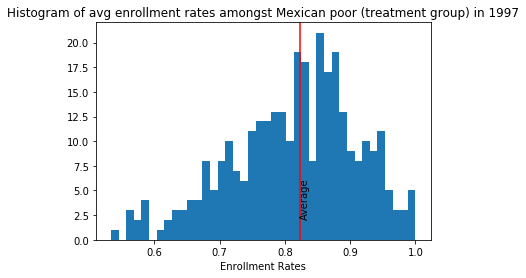

In [265]:
poorTreated97 = data[(data["year"] == 97) & (data["poor"] == 1) & (data["progresa"]==1)]

x97 = poorTreated97.groupby(['village'])['sc'].mean()
plt.hist(x97, bins=40)
plt.axvline(poorTreated97.sc.mean(), color='red')
plt.text(poorTreated97.sc.mean(), 5.5, 'Average',rotation=90)
plt.title("Histogram of avg enrollment rates amongst Mexican poor (treatment group) in 1997")
plt.xlabel("Enrollment Rates")
plt.show()

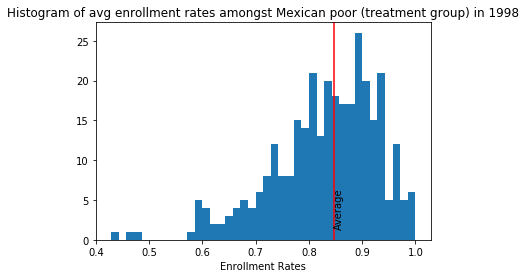

In [266]:
poorTreated98 = data[(data["year"] == 98) & (data["poor"] == 1) & (data["progresa"]==1)]

x98 = poorTreated98.groupby(['village'])['sc'].mean()
plt.hist(x98, bins=40)
plt.axvline(poorTreated98.sc.mean(), color='red')
plt.text(poorTreated98.sc.mean(), 5.5, 'Average',rotation=90)
plt.title("Histogram of avg enrollment rates amongst Mexican poor (treatment group) in 1998")
plt.xlabel("Enrollment Rates")
plt.show()

From above we can conclude that:
* The enrollment rate amongst the poor children follow a skewed normal distribution for both the years.
* Also, it seems like the enrollment rate has increased in 1998 than as compared to 1997 as demonstrated by the left skewed plot of the enrollment rates histogram
* This is indicative of the fact that within the treatment group the number of enrollments went up in the Progresea program

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on
the social and economic outcomes of individuals in Mexico. We will
focus on the impact of the program on the poor (those with
poor=='pobre'), since only the poor were eligible to receive the
PROGRESA assistance.

### 2.1 Cross-Sectional Estimator: T-test

Begin by estimating the impact of Progresa using "simple differences."
Restricting yourself to data from 1998 (after treatment), calculate
the average enrollment rate among **poor** households in the Treatment
villages and the average enrollment rate among **poor** households in
the control villages. Use a t-test to determine if this difference is
statistically significant. What do you conclude?

In [300]:
# Year 1998; Poor People; Treatment group
poorTreated98 = data[(data["year"] == 98) & (data["poor"] == 1) & (data["progresa"]==1)].dropna()

# Year 1998; Poor People; Control group
poorControl98 = data[(data["year"] == 98) & (data["poor"] == 1) & (data["progresa"]==0)].dropna()

#Calculating the t-statistic
print('Average Enrollment for Treatment villages in 1998:', np.round(poorTreated98.sc.mean(),5))
print('Average Enrollment for Control Villages in 1998:', np.round(poorControl98.sc.mean(),5))
print('Difference in Average: (Treat-Control):', np.round(poorTreated98.sc.mean()-poorControl98.sc.mean(),5))
stats.ttest_ind(poorTreated98.sc.values, poorControl98.sc.values)

Average Enrollment for Treatment villages in 1998: 0.84926
Average Enrollment for Control Villages in 1998: 0.81092
Difference in Average: (Treat-Control): 0.03833


Ttest_indResult(statistic=8.101650305300375, pvalue=5.656455605358843e-16)

* The p-value is significantly less than 0.05 which shows that the difference is statisitcally significant
* Thus, this proves that there is an improvement in enrollment rate post treatment in 1998 amongst the poor Mexicans

### 2.2 Cross-Sectional Estimator: Regression

Estimate the effects of Progresa on enrollment using a regression
model, by regressing the 1998 enrollment rates **of the poor** on
treatment assignment.  Do not include any additional control
variables.
Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

Note: I recommend to use statsmodels.formula.api as this allows to use
convenient R-style formulas and provedes nice summaries of the results.

In [301]:
dat = data[(data["year"] == 98) & (data["poor"] == 1)]
model = smf.ols(formula = 'sc ~ progresa', data=dat).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Fri, 01 Mar 2019   Prob (F-statistic):           6.64e-17
Time:                        00:23:32   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8076      0.004    220.676      0.0

From the above test we can conclude that, 
* The program (treatment) has increased the likelihood of enrollment by 3.8% (as indicated by the intercept). Note that this is consistent with the difference in the mean values of the treatment and the control group in the previous part.
* The t-test values of this part is similar to the one calculated in the previous part
* Based on this model, we can reject the null hypothesis (as p-value << 0.05), stating that there is no effect of the treatment.
* An important assumptions is the fact that the means for both treatment and the control groups will be the same implying that essentially both the groups are actually the same.

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of
relevant control variables. Include, for instance, age, distance to a secondary
school, gender, education of household head, welfare index,
indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [302]:
model = smf.ols(formula = 'sc ~ age + dist_sec + sex + hohedu + indig + min_dist + progresa', data=dat).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     1459.
Date:                Fri, 01 Mar 2019   Prob (F-statistic):               0.00
Time:                        00:23:40   Log-Likelihood:                -7592.2
No. Observations:               27340   AIC:                         1.520e+04
Df Residuals:                   27332   BIC:                         1.527e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4673      0.010    141.211      0.0

From this model we can conclude that: 
* The control variables such as age, dist_sec etc, reduce the estimate point of treatment effects from 3.83% to 3.3%
* The standard error is reduced from 0.005 to 0.004
* In this model as compared to the previous one, we see the reduction in point estimate of the progresa variable. However, still it is relatively small and hence other variables are not able to explain the outcome very well.

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the
difference in 1998 enrollment rates across villages. An alternative
approach would be to compute the treatment effect using a
difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate:

a) the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages

b) the difference (between 1997 and 1998) in enrollment rates among poor households in control villages.

c) The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?

* What is the counterfactual assumption underlying this estimate? 


In [303]:
# Year 1997; Poor People; Treatment group
poorTreated97 = data[(data["year"] == 97) & (data["poor"] == 1) & (data["progresa"]==1)].dropna()

# Year 1997; Poor People; Control group
poorControl97 = data[(data["year"] == 97) & (data["poor"] == 1) & (data["progresa"]==0)].dropna()

# Year 1998; Poor People; Treatment group
poorTreated98 = data[(data["year"] == 98) & (data["poor"] == 1) & (data["progresa"]==1)].dropna()

# Year 1998; Poor People; Control group
poorControl98 = data[(data["year"] == 98) & (data["poor"] == 1) & (data["progresa"]==0)].dropna()

In [304]:
diffTreatment = poorTreated98.sc.mean() - poorTreated97.sc.mean()
diffControl = poorControl98.sc.mean() - poorControl97.sc.mean()
print("\nDifference in Treatment groups of 1997 and 1998 is", diffTreatment)
print("\nDifference in Control groups of 1997 and 1998 is", diffControl)
print("\nDifference in Difference is", diffTreatment - diffControl)


Difference in Treatment groups of 1997 and 1998 is 0.02656050742564997

Difference in Control groups of 1997 and 1998 is -0.004142465805002105

Difference in Difference is 0.030702973230652075


* The difference in difference value comes out to be 0.0307 which is slightly similar to the controls estimate of 0.0329 but much lower than than the simple estimate 0.0383 as depicted above

* The assumption is that the difference between the control and the treatment groups represents the counterfactual change in the treatment group if there were no treatment.

### 2.5 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment
effects of the program in a difference-in-differences
framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in
  interpreting your coefficients and standard errors, and make sure to
  specify exactly what units you are measuring and estimating.

* How do these estimates of the treatment effect compare to the
  estimates based on the simple difference?

* How do these estimates compare to the difference-in-difference
  estimates from 2.4 above? What accounts for these differences?

* What is the counterfactual assumption underlying this regression? 

In [308]:
dat = data[data['poor']==1]

#categoriziing year; 97 is categorized as 0 and 98 as 1
dat.year = dat['year'].map({97: 0, 98: 1})

model = smf.ols(formula ='sc ~ progresa + year + progresa:year + age + dist_sec + sex + hohedu + indig', 
                data = dat, missing='drop').fit()
print(model.summary())
#dat.head()
#dat.year

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2810.
Date:                Fri, 01 Mar 2019   Prob (F-statistic):               0.00
Time:                        00:24:46   Log-Likelihood:                -16717.
No. Observations:               58165   AIC:                         3.345e+04
Df Residuals:                   58156   BIC:                         3.353e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4940      0.006    231.606

* Estimate of impact with the controls and interaction terms comes out to 0.0314 with a p-value less than 0.05 which shows that it is statistically significant. Also, if we look at progresa without interaction, the estimate is 0.0043 and it is not significant as well since p-value = 0.256 which is larger than 0.05. 

* In the previous estimates, we only considered the post-progresa data and ignored the pre-progresea data. In this estimate, we notice the difference in treatment and control in both pre and post progresa.

* There is a little decrease in the progresea estimate from 0.0329 in the previous case to 0.0314 in this case. This can also be explained due to the other variables explaining a little effect in the regression.

* The assumption is that the difference between the control and the treatment groups represents the counterfactual change in the treatment group if there were no treatment.



### 2.6 Summary

* Based on all the analysis you have undertaken to date, do you
  believe that Progresa had a causal impact on the enrollment rates of
  poor households in Mexico?  Explain by referring to the methods and
  results above.

Based on the baove analysis it is safe to infer that the program progresa did have an effect, although not as significant as one might expect, on the enrollemnt rates of poor children in Mexico. 

Although this difference is not significant, yet beased on the results we got using the various methods, we can say that Progresa had an impact on the enrollment rates of children in school belonging to poor families. However, we should be wary of the fact that the treatment is received only by the ones who need it.